# Post-Training: Evaluate Error in Curvature Estimation

In [1]:
import setup

setup.main()

Working directory:  /home/nmiolane/code/neuralgeom/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom/neuralgeom


In [2]:
%load_ext autoreload
%autoreload 2

import json
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"


import geomstats.backend as gs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

INFO: Using pytorch backend


## Evaluate error with respect to the embedding dimension

In [3]:
ed = [
    2,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
]

curvature_error_ed = [
    0.001689126,
    0.001012303,
    0.002482807,
    0.001903473,
    0.002538689,
    0.002346822,
    0.00185122,
    0.002858928,
    0.001734209,
    0.004227371,
    0.003866927,
    0.0020231,
    0.001000167,
    0.001913845,
    0.002814295,
    0.002451746,
    0.00226067,
    0.003887875,
    0.00125866,
    0.000970031,
    0.001079341,
    0.003844655,
]

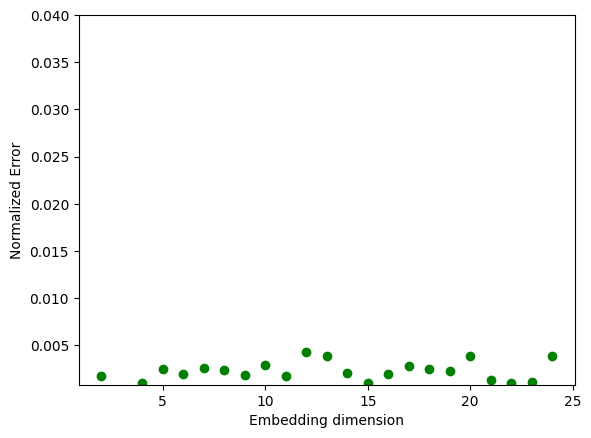

In [4]:
plt.scatter(ed, curvature_error_ed, color="green")
plt.ylim(top=0.04)
plt.xlabel("Embedding dimension")
plt.ylabel("Normalized Error");

## Evaluate error with respect to the noise variance

Text(0, 0.5, 'Normalized Error')

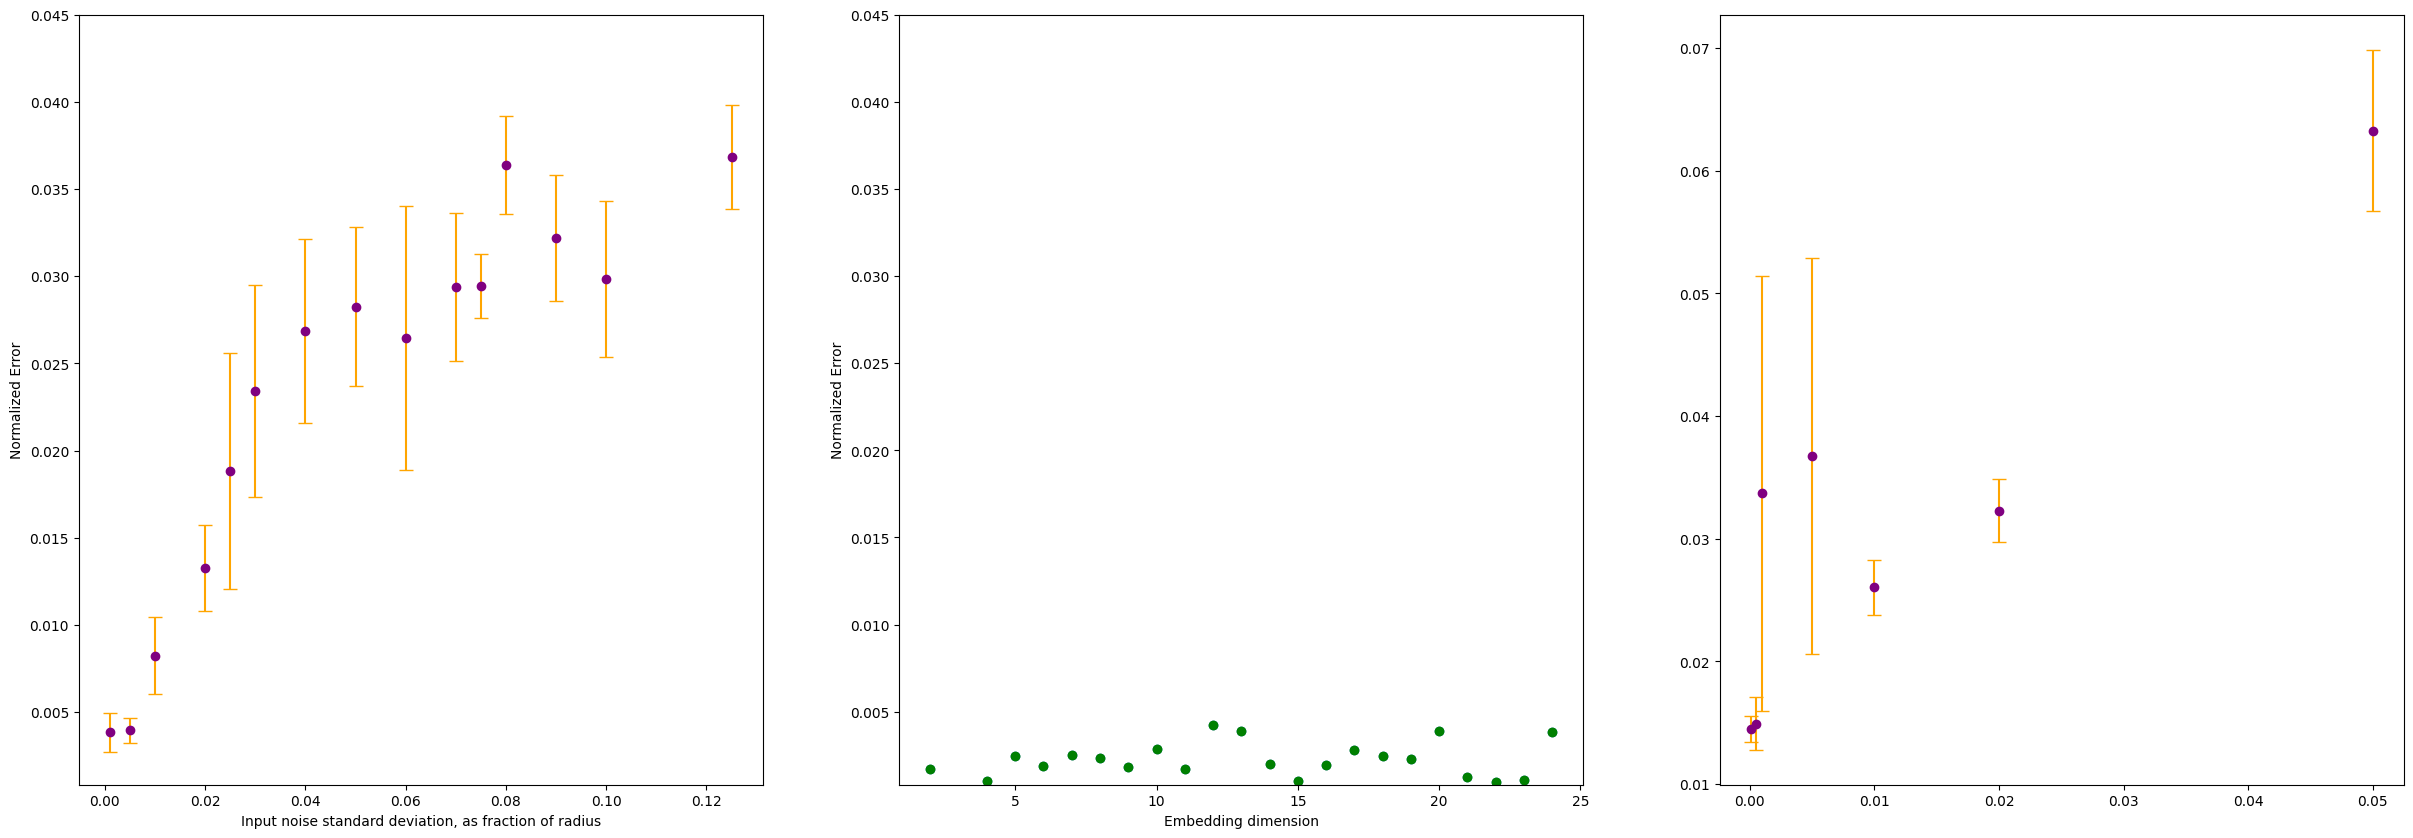

In [5]:
fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(131)

noise_var = [
    0.001,
    0.005,
    0.01,
    0.02,
    0.025,
    0.03,
    0.04,
    0.05,
    0.06,
    0.07,
    0.075,
    0.08,
    0.09,
    0.1,
    0.125,
]


curvature_error_noise = [
    0.0038236,
    0.00393826,
    0.0082392,
    0.013263643,
    0.018831209,
    0.023393472,
    0.026830469,
    0.028257823,
    0.026462683,
    0.029377216,
    0.029433391,
    0.036400927,
    0.032171806,
    0.029818693,
    0.036835936,
]


std = [
    0.00255255,
    0.00162342,
    0.00494583,
    0.005526395,
    0.015162444,
    0.013581833,
    0.011809724,
    0.010161061,
    0.01691731,
    0.009538343,
    0.004111763,
    0.006278068,
    0.00807038,
    0.010022126,
    0.00662975,
]

std = std / np.sqrt(5)

ax.errorbar(
    x=noise_var,
    y=curvature_error_noise,
    yerr=std,
    fmt="o",
    ecolor="orange",
    capsize=5,
    color="purple",
)
plt.xlabel("Input noise standard deviation, as fraction of radius")
plt.ylabel("Normalized Error")
plt.ylim(top=0.045)

# plt.savefig("est_theory.svg")
noise_vars2 = [0.02, 0.05, 0.01, 0.005, 0.0005, 0.001, 0.0001]

curvature_errors_noise2 = [
    0.032287827,
    0.063259569,
    0.026015801,
    0.036729573,
    0.014929154,
    0.033680042,
    0.01449421,
]

stds2 = [
    0.00579972,
    0.014732794,
    0.005003834,
    0.036167766,
    0.004776713,
    0.039667175,
    0.002329629,
] / np.sqrt(5)

axs2 = fig.add_subplot(133)

axs2.errorbar(
    x=noise_vars2,
    y=curvature_errors_noise2,
    yerr=stds2,
    fmt="o",
    color="purple",
    ecolor="orange",
    capsize=5,
)


ax3 = fig.add_subplot(132)

ax3.scatter(ed, curvature_error_ed)

ax3.set_xlabel("Input noise standard deviation, as fraction of radius")
plt.ylabel("Normalized Error")


ax3.scatter(ed, curvature_error_ed, color="green")
plt.ylim(top=0.045)
plt.xlabel("Embedding dimension")
plt.ylabel("Normalized Error")


# plt.savefig("error.svg")

In [6]:
import setup

setup.main()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import wandb

Working directory:  /home/nmiolane/code/neuralgeom/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom
Directory added to path:  /home/nmiolane/code/neuralgeom/neuralgeom


In [7]:
import importlib

import evaluate
import load_runs

importlib.reload(evaluate)
importlib.reload(load_runs)

<module 'load_runs' from '/home/nmiolane/code/neuralgeom/neuralgeom/notebooks/load_runs.py'>

# Get Learned and True Curvature Profiles

In [8]:
run_id = "354e4bdc"
config = load_runs.config_from_run_id(run_id)
learned_profile, true_profile = load_runs.curvature_profiles_from_run_id(run_id, config)

In [9]:
learned_profile.head()

,Unnamed: 0,geodesic_dist,curv_norm_learned,z_grid_theta,z_grid_phi
0,0,0.0,379561.286021,0.01,0.000000
1,1,0.0,400459.983392,0.01,0.698132
2,2,0.0,425307.644375,0.01,1.396263
3,3,0.0,443282.731994,0.01,2.094395
4,4,0.0,445239.979779,0.01,2.792527


In [10]:
true_profile.head()

,Unnamed: 0,geodesic_dist,curv_norm_true,z_grid_theta,z_grid_phi
0,0,0.0,5.504101,0.01,0.000000
1,1,0.0,5.504101,0.01,0.698132
2,2,0.0,5.504101,0.01,1.396263
3,3,0.0,5.504101,0.01,2.094395
4,4,0.0,5.504101,0.01,2.792527


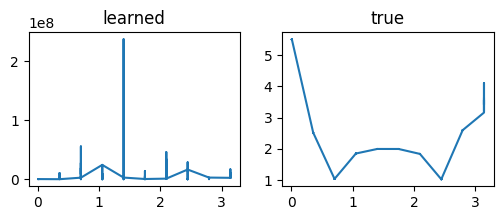

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2))

axs[0].plot(learned_profile["z_grid_theta"], learned_profile["curv_norm_learned"])
axs[0].set_title("learned")
axs[1].plot(true_profile["z_grid_theta"], true_profile["curv_norm_true"])
axs[1].set_title("true");

In [12]:
z_grid = np.vstack([true_profile["z_grid_theta"], true_profile["z_grid_phi"]]).T
print(z_grid.shape)
print(z_grid[:10])

curvature_error = evaluate.compute_curvature_error(
    torch.tensor(z_grid),
    torch.tensor(learned_profile["curv_norm_learned"].values),
    torch.tensor(true_profile["curv_norm_true"].values),
    config,
)
curvature_error

(100, 2)
[[0.01       0.        ]
 [0.01       0.6981317 ]
 [0.01       1.3962634 ]
 [0.01       2.0943951 ]
 [0.01       2.7925268 ]
 [0.01       3.4906585 ]
 [0.01       4.1887902 ]
 [0.01       4.88692191]
 [0.01       5.58505361]
 [0.01       6.28318531]]


tensor(1.0000)

# Use wandb API to get most recent runs

In [13]:
api = wandb.Api()
runs = api.runs("bioshape-lab/neuralgeom")
today = pd.to_datetime("2023-03-09")

df_list = []
for i_run, run in enumerate(runs):
    if pd.to_datetime(run.createdAt) > today:
        run_dict = {}
        run_dict.update(run.summary._json_dict)
        config_dict = {
            k: v
            for k, v in run.config.items()
            if (k != "wandb" and not k.startswith("_"))
        }
        run_dict.update(config_dict)
        df_list.append(pd.DataFrame(run_dict, index=[i_run]))
runs_df = pd.concat(df_list)

In [14]:
len(runs_df)

2549

In [15]:
by_to_color = {"noise_var": "orange", "embedding_dim": "darkgreen"}

In [16]:
def _recompute_curvature_error(df):
    for i_row, row in df.iterrows():
        run_id = row["run_name"].split("_")[
            1
        ]  # da1b8070"  # "fcd255d1" #"ep3kxahu" #"aeb2dbeb"
        config = load_runs.config_from_run_id(run_id)
        learned_profile, true_profile = load_runs.curvature_profiles_from_run_id(
            run_id, config
        )
        z_grid = np.vstack([true_profile["z_grid_theta"], true_profile["z_grid_phi"]]).T
        curvature_error = evaluate.compute_curvature_error(
            torch.tensor(z_grid),
            torch.tensor(learned_profile["curv_norm_learned"]),
            torch.tensor(true_profile["curv_norm_true"]),
            config,
        )
        df.loc[i_row, "curvature_error"] = float(curvature_error)
    return df

In [17]:
dataset_name_to_std_threshold = {"s1_synthetic": 1, "s2_synthetic": 2}

In [18]:
def plot_errorbar_by(
    df,
    dataset_name="s1_synthetic",
    by="noise_var",
    select="embedding_dim",
    select_value=2,
    ax=None,
):
    df = df[
        [
            "run_name",
            "embedding_dim",
            "noise_var",
            "curvature_error",
            "train_loss",
            "test_loss",
            "train_recon_loss",
            "test_recon_loss",
            "test_latent_loss",
            "average_curv_norms_learned",
            "average_curv_norms_true",
            "std_curv_norms_learned",
        ]
    ][df["dataset_name"] == dataset_name]
    df = df[df[select] == select_value]
    # print("pre-dropna:", np.unique(df[by]))
    df = df.dropna()
    # # Remove high curvatures
    # df = df[df["average_curv_norms_learned"] < 1.5 * df[ "average_curv_norms_true"]]
    # df = df[df["std_curv_norms_learned"] < dataset_name_to_std_threshold[dataset_name]]
    # print("post-dropna:", np.unique(df[by]))
    df["average_curv_norms_learned"] = df["average_curv_norms_learned"].astype(float)
    df["std_curv_norms_learned"] = df["std_curv_norms_learned"].astype(float)

    grouped = df.groupby(by)
    # print(f"Grouped by: {by} = : Found {len(grouped)} groups, for {len(df)} eligible runs.")
    lowest_losses = grouped.apply(
        lambda x: x.nsmallest(5, "std_curv_norms_learned")
    )
    df = lowest_losses.reset_index(drop=True)

    grouped = df.groupby(by)
    lowest_losses = grouped.apply(lambda x: x.nsmallest(4, "average_curv_norms_learned"))
    df = lowest_losses.reset_index(drop=True)

    # grouped = df.groupby(by)
    # lowest_losses = grouped.apply(lambda x: x.nsmallest(5, "test_recon_loss"))
    # df = lowest_losses.reset_index(drop=True)

    if dataset_name == "s2_synthetic":
        df = _recompute_curvature_error(df)
    mean_dict = {}
    std_dict = {}

    unique_by = np.unique(df[by])
    for by_val in unique_by:
        mean_dict[by_val] = np.nanmean(df["curvature_error"][df[by] == by_val])
        std_dict[by_val] = np.nanstd(df["curvature_error"][df[by] == by_val])
    ax.scatter(df[by], df["curvature_error"], c="purple", alpha=0.2)
    # ax.plot(
    #     [k for k in mean_dict.keys()],
    #     [v for v in mean_dict.values()],
    #     linewidth=2,
    #     c="purple",
    # )
    ax.errorbar(
        [k for k in mean_dict.keys()],
        [v for v in mean_dict.values()],
        [v for v in std_dict.values()],
        fmt="o",
        ecolor=by_to_color[by],
        capsize=5,
        color="purple",
    )
    try:
        ax.set_ylim((0, df["curvature_error"].max()))
    except:
        ax.set_ylim((0, 1))
    ax.set_xlabel(by)
    ax.set_ylabel("curvature_error")
    ax.set_title(f"{dataset_name}\n selected: {select} = {select_value}")
    return

### Estimation Evaluation: S1 Synthetic

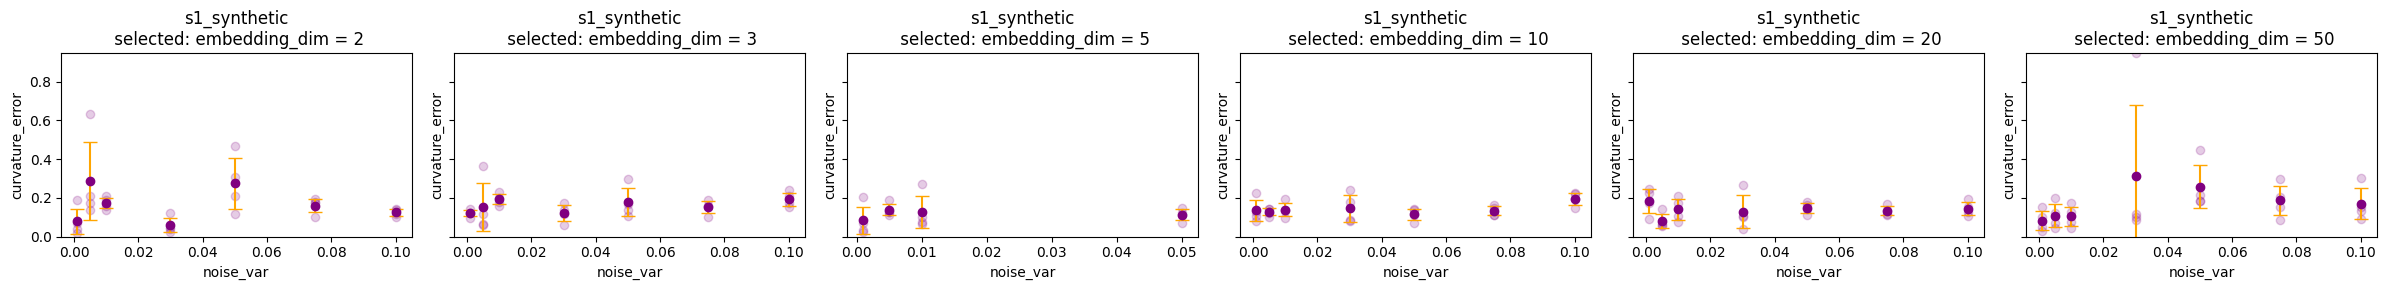

In [19]:
EMBEDDING_DIMS = [2, 3, 5, 10, 20, 50]
dataset_name = "s1_synthetic"
by = "noise_var"

fig, axes = plt.subplots(
    nrows=1, ncols=len(EMBEDDING_DIMS), figsize=(24, 3), sharey=True
)

for i, embedding_dim in enumerate(EMBEDDING_DIMS):
    plot_errorbar_by(
        runs_df,
        dataset_name=dataset_name,
        by="noise_var",
        select="embedding_dim",
        select_value=embedding_dim,
        ax=axes[i],
    )
plt.tight_layout()
fig.savefig(f"notebooks/figures/estimation_{dataset_name}_{by}.svg")

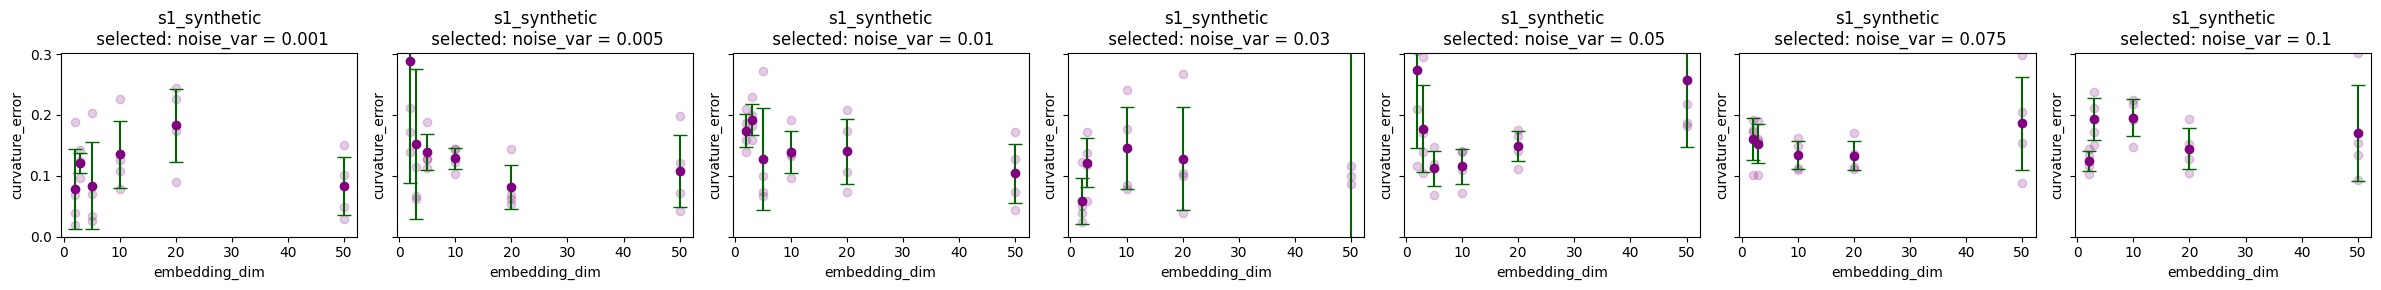

In [20]:
NOISE_VARS = [0.001, 0.005, 0.01, 0.03, 0.05, 0.075, 0.1]  # 0.0,

by = "embedding_dim"
fig, axes = plt.subplots(nrows=1, ncols=len(NOISE_VARS), figsize=(24, 3), sharey=True)

for i, noise_var in enumerate(NOISE_VARS):
    plot_errorbar_by(
        runs_df,
        dataset_name=dataset_name,
        by="embedding_dim",
        select="noise_var",
        select_value=noise_var,
        ax=axes[i],
    )
plt.tight_layout()
fig.savefig(f"notebooks/figures/estimation_{dataset_name}_{by}.svg")

### Estimation Evaluation: S2 Synthetic

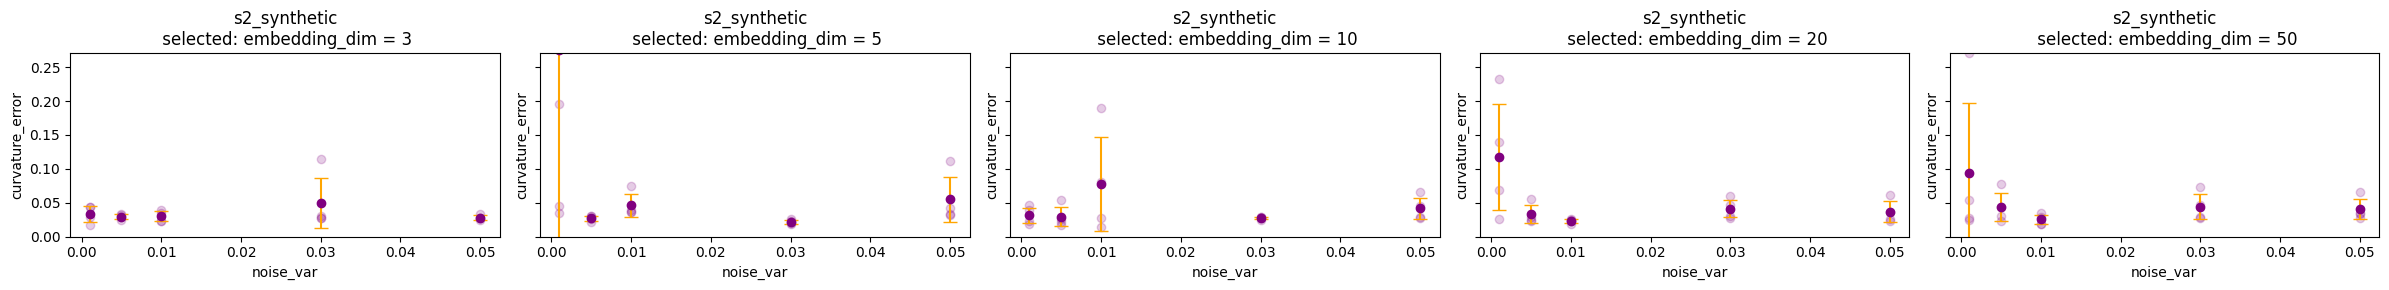

In [21]:
EMBEDDING_DIMS = [3, 5, 10, 20, 50]
dataset_name = "s2_synthetic"
by = "noise_var"


fig, axes = plt.subplots(nrows=1, ncols=len(EMBEDDING_DIMS), figsize=(24, 3), sharey=True)

for i, embedding_dim in enumerate(EMBEDDING_DIMS):
    df = plot_errorbar_by(
        runs_df,
        dataset_name="s2_synthetic",
        by="noise_var",
        select="embedding_dim",
        select_value=embedding_dim,
        ax=axes[i],
    )
plt.tight_layout()
fig.savefig(f"notebooks/figures/estimation_{dataset_name}_{by}.svg")

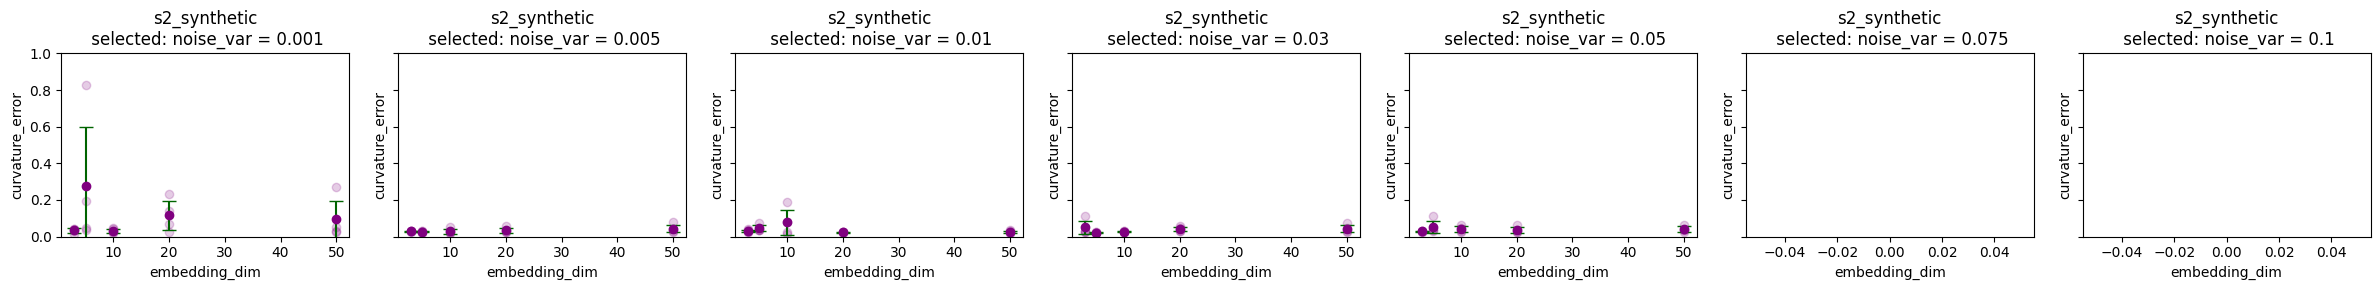

In [22]:
NOISE_VARS = [0.001, 0.005, 0.01, 0.03, 0.05, 0.075, 0.1]  # 0.0,

by = "embedding_dim"
fig, axes = plt.subplots(nrows=1, ncols=len(NOISE_VARS), figsize=(24, 3), sharey=True)

for i, noise_var in enumerate(NOISE_VARS):
    plot_errorbar_by(
        runs_df,
        dataset_name="s2_synthetic",
        by="embedding_dim",
        select="noise_var",
        select_value=noise_var,
        ax=axes[i],
    )
plt.tight_layout()
fig.savefig(f"notebooks/figures/estimation_{dataset_name}_{by}.svg")